# Imports & Paths

In [1]:
from PIL import Image
from google.colab import userdata
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
try:
    from torchinfo import summary as info
except:
    !pip install torchinfo
    from torchinfo import summary as info

import pandas as pd
import matplotlib.pyplot as plt

import json
import os

from IPython.core.magic import register_cell_magic
@register_cell_magic
def skip(line, cell):
    print(line)
    return



In [2]:
project_path = userdata.get('PATH_PROJECT')
dataset_path = os.path.join(project_path, 'dataset')

train_path = os.path.join(dataset_path, 'train_metadata.json')
test_path = os.path.join(dataset_path, 'test_metadata.json')

import sys
src_path = os.path.join(project_path, 'src')
sys.path.append(src_path)



# The Data & Dataset Class

In [3]:
with open(train_path) as train, open(test_path) as test:
    train_samples = json.load(train)
    test_samples = json.load(test)

# Get the scores for the training and testing sets
train_scores = [sample['score'] for sample in train_samples]
test_scores = [sample['score'] for sample in test_samples]

# Calculate the distribution of scores
train_score_distribution = pd.Series(train_scores).value_counts().sort_index()
test_score_distribution = pd.Series(test_scores).value_counts().sort_index()

# Display the distributions
print("Train set score distribution:")
display(train_score_distribution)

print("\nTest set score distribution:")
display(test_score_distribution)

Train set score distribution:


,count
0.0,1594
0.5,497
1.0,867



Test set score distribution:


,count
0.0,389
0.5,127
1.0,224


In [13]:
from PairedImageDataset import PairedImageDataset

# Create dataset instances
train_dataset = PairedImageDataset(root_dir=dataset_path, metadata_json_path=train_path)
test_dataset = PairedImageDataset(root_dir=dataset_path, metadata_json_path=test_path)

# Create dataloader instances
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True, num_workers=2)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")
print(f"Batch size: {batch_size}")

Number of training samples: 2958
Number of testing samples: 740
Batch size: 32


# Model & Training

Stack two images togther (6 x 20 x 20) tensor.
No augmentations.
MSE loss.
Layers:
1. CNN [in=6, out=6, kernel=3]
2. CNN [in=6, out=3, kernel=1]
3. CNN [in=3, out=1, kernel=3]
4. Flatten
5. Linear Layer [..., 1]
6. Sigmoid


In [10]:
import torch
import torch.nn as nn

class ImageComparisonModel(nn.Module):
    def __init__(self):
        super(ImageComparisonModel, self).__init__()
        self.cnn_layers = nn.Sequential(
            # Layer 1: CNN [in=6, out=6, kernel=3]
            nn.Conv2d(in_channels=6, out_channels=6, kernel_size=3, padding=1),
            nn.ReLU(), # Added ReLU activation
            # Layer 2: CNN [in=6, out=3, kernel=1]
            nn.Conv2d(in_channels=6, out_channels=3, kernel_size=1),
            nn.ReLU(), # Added ReLU activation
            # Layer 3: CNN [in=3, out=1, kernel=3]
            nn.Conv2d(in_channels=3, out_channels=1, kernel_size=3, padding=1),
            nn.ReLU() # Added ReLU activation
        )
        self.flatten = nn.Flatten()
        # Layer 5: Linear Layer [..., 3] - Output size changed to 3 for 3 classes
        self.linear_layer = nn.Linear(in_features=1*20*20, out_features=3) # Output features changed to 3
        # Removed Sigmoid activation for classification
        # self.sigmoid = nn.Sigmoid()

    def forward(self, img_clean, img_other):
        # Stack images together: (batch_size, 6, H, W)
        combined_images = torch.cat((img_clean, img_other), dim=1)

        # Pass through CNN layers
        cnn_output = self.cnn_layers(combined_images)

        # Flatten the output
        flattened_output = self.flatten(cnn_output)

        # Pass through linear layer
        linear_output = self.linear_layer(flattened_output)

        # For classification, we return the raw logits
        # output = self.sigmoid(linear_output) # Removed Sigmoid

        return linear_output # Return logits

# Instantiate the model
model = ImageComparisonModel()
# Use torchinfo.summary for models with multiple inputs
display(info(model, input_size=[(1, 3, 20, 20), (1, 3, 20, 20)], device='cpu')) # Providing shapes for img_clean and img_other

Layer (type:depth-idx)                   Output Shape              Param #
ImageComparisonModel                     [1, 3]                    --
├─Sequential: 1-1                        [1, 1, 20, 20]            --
│    └─Conv2d: 2-1                       [1, 6, 20, 20]            330
│    └─ReLU: 2-2                         [1, 6, 20, 20]            --
│    └─Conv2d: 2-3                       [1, 3, 20, 20]            21
│    └─ReLU: 2-4                         [1, 3, 20, 20]            --
│    └─Conv2d: 2-5                       [1, 1, 20, 20]            28
│    └─ReLU: 2-6                         [1, 1, 20, 20]            --
├─Flatten: 1-2                           [1, 400]                  --
├─Linear: 1-3                            [1, 3]                    1,203
Total params: 1,582
Trainable params: 1,582
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.15
Input size (MB): 0.01
Forward/backward pass size (MB): 0.03
Params size (MB): 0.01
Estimated Total Size (MB): 0.0

In [17]:
# Define the loss function (Cross Entropy for classification)
criterion = nn.CrossEntropyLoss()

# Define the optimizer (Adam is a good general-purpose optimizer)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # You can adjust the learning rate as needed

# Define the device: GPU if available, CPU otherwise
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Loss function:", criterion)
print("Optimizer:", optimizer)
print("Device:", device)

Loss function: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Device: cpu


In [16]:
# Get a batch from the test dataloader
img_clean, img_other, score = next(iter(test_dataloader))

# Move data to the same device as the model (if using GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
img_clean = img_clean.to(device)
img_other = img_other.to(device)

# Perform a forward pass
with torch.no_grad(): # No need to calculate gradients for a test pass
    output = model(img_clean, img_other)

# Print the output shape and a few values
print("Model output shape:", output.shape)
print("Sample model outputs:", output[:5].squeeze()) # Print first 5 outputs
print("Sample true scores:", score[:5]) # Print first 5 true scores

Model output shape: torch.Size([32, 3])
Sample model outputs: tensor([[ 0.3117, -0.7287,  0.2347],
        [ 0.3340, -0.7710,  0.2255],
        [ 0.3359, -0.8154,  0.2127],
        [ 0.3274, -0.7857,  0.2190],
        [ 0.3171, -0.7453,  0.2213]])
Sample true scores: tensor([1, 0, 1, 2, 0])


## Training loop

In [18]:
# Training loop
num_epochs = 10 # You can adjust the number of epochs

# Set the model to training mode & Move the model to device
model.train()
model.to(device)

for epoch in range(num_epochs):
    running_loss = 0.0
    correct_train_predictions = 0
    total_train_samples_epoch = 0

    print(f"Start Epoch [{epoch+1}/{num_epochs}]")

    # Iterate over the training data in batches
    for i, (img_clean, img_other, class_indices) in enumerate(train_dataloader):
        # Move batch data to the device, if not preloaded
        if not train_dataset.preload:
             img_clean = img_clean.to(device)
             img_other = img_other.to(device)
             class_indices = class_indices.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        # Model outputs are now logits for each class: (batch_size, num_classes)
        outputs = model(img_clean, img_other)

        # Calculate the loss
        # CrossEntropyLoss expects outputs to be (batch_size, num_classes) and targets to be (batch_size) with class indices (dtype=long)
        loss = criterion(outputs, class_indices.long()) # Ensure target class indices are long type

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * img_clean.size(0) # Accumulate loss, weighted by batch size
        total_train_samples_epoch += img_clean.size(0)

        # Calculate training accuracy for the batch
        # Get predicted class indices by taking the argmax of the outputs (logits)
        _, predicted_train_classes = torch.max(outputs, 1)
        correct_train_predictions += (predicted_train_classes == class_indices.long()).sum().item() # Ensure target class indices are long type

    # Calculate average epoch loss and training accuracy
    epoch_loss = running_loss / total_train_samples_epoch
    train_accuracy = correct_train_predictions / total_train_samples_epoch


    # Print epoch loss and training accuracy
    print(f"End Epoch [{epoch+1}/{num_epochs}]")
    print(f"Average Training Loss: {epoch_loss:.4f}")
    print(f"Training Accuracy: {train_accuracy:.4f}")


    # Evaluation on test data (can still process in batches for memory efficiency)
    model.eval()
    test_loss = 0.0
    correct_test_predictions = 0
    total_test_samples_epoch = 0

    with torch.no_grad():
        for img_clean, img_other, class_indices in test_dataloader:
             # Move batch data to the device, if not preloaded
             if not test_dataset.preload:
                 img_clean = img_clean.to(device)
                 img_other = img_other.to(device)
                 class_indices = class_indices.to(device)

             test_outputs = model(img_clean, img_other)
             test_loss += criterion(test_outputs, class_indices.long()).item() * img_clean.size(0) # Accumulate loss

             # Calculate test accuracy for the batch
             _, predicted_test_classes = torch.max(test_outputs, 1)
             correct_test_predictions += (predicted_test_classes == class_indices.long()).sum().item() # Ensure target class indices are long type
             total_test_samples_epoch += img_clean.size(0)

    # Calculate average test loss and accuracy
    test_loss /= total_test_samples_epoch
    test_accuracy = correct_test_predictions / total_test_samples_epoch

    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")


print("Training finished!")

Start Epoch [1/10]
End Epoch [1/10]
Average Training Loss: 1.0030
Training Accuracy: 0.5377


KeyboardInterrupt: 

## Save the model

In [ ]:
%%skip Comment out skip to save the model

# Define the path to save the model
model_save_path = os.path.join(project_path, 'src/image_comparison_model.pth')

# Save the model's state dictionary
torch.save(model.state_dict(), model_save_path)

print(f"Model saved to: {model_save_path}")

Model saved to: /content/drive/MyDrive/Colab Notebooks/Samsung/image_comparison_model.pth


# Evaluation
Compute the confusion matrix for the test set predictions and true scores, using the bins [0-0.3, 0.3-0.6, 0.6-1] and the labels [RED, ORANGE, GREEN].

## Run inference on the test set

Use the trained model to get predictions for all samples in the test dataset.


In [19]:
# Set the model to evaluation mode
model.eval()

# Disable gradient calculation
with torch.no_grad():
    # Get predictions for the test set by iterating through the test_dataloader
    all_test_outputs = []
    all_test_class_indices = [] # Store true class indices for evaluation

    for img_clean, img_other, class_indices in test_dataloader:
        # Move batch data to the device (if not preloaded)
        if not test_dataset.preload:
            img_clean = img_clean.to(device)
            img_other = img_other.to(device)
            class_indices = class_indices.to(device)

        test_outputs = model(img_clean, img_other)
        all_test_outputs.append(test_outputs.cpu()) # Move to CPU for concatenation and later processing
        all_test_class_indices.append(class_indices.cpu()) # Move true indices to CPU

    # Concatenate all batch outputs and true class indices
    all_test_outputs = torch.cat(all_test_outputs, dim=0)
    all_test_class_indices = torch.cat(all_test_class_indices, dim=0)


print("All test outputs shape:", all_test_outputs.shape)
print("All true test class indices shape:", all_test_class_indices.shape)
print("Sample test outputs (logits):", all_test_outputs[:5].squeeze())
print("Sample true test class indices:", all_test_class_indices[:5])

All test outputs shape: torch.Size([736, 3])
All true test class indices shape: torch.Size([736])
Sample test outputs (logits): tensor([[ 0.4209, -0.6457, -0.0028],
        [ 0.4594, -0.6999, -0.0161],
        [ 0.4865, -0.7750, -0.0368],
        [ 0.4605, -0.7308, -0.0251],
        [ 0.4306, -0.6641, -0.0158]])
Sample true test class indices: tensor([1, 0, 1, 2, 0])


## Digitize predictions

Convert the continuous model outputs into discrete labels (bins [0-0.3, 0.3-0.6, 0.6-1]).


In [25]:
# Get predicted class indices by taking the argmax of the logits
# The argmax along dimension 1 gives the index of the maximum logit for each sample in the batch
predicted_test_class_indices = torch.argmax(all_test_outputs, dim=1)

# Convert indices to labels if needed for clarity in some metrics, but indices are fine for confusion matrix and most metrics
labels = ['RED', 'ORANGE', 'GREEN']
predicted_test_labels = [labels[i] for i in predicted_test_class_indices.tolist()]


print("Predicted test class indices shape:", predicted_test_class_indices.shape)
print("Sample predicted test class indices:", predicted_test_class_indices[:5])
print("Sample predicted test labels:", predicted_test_labels[:5])

Predicted test class indices shape: torch.Size([736])
Sample predicted test class indices: tensor([0, 0, 0, 0, 0])
Sample predicted test labels: ['RED', 'RED', 'RED', 'RED', 'RED']


## Digitize true scores

Convert the continuous true scores from the test set into the same discrete labels using the same bins.


In [26]:
# The true test class indices are already stored in all_test_class_indices
# which were collected during the inference step.

# Convert true indices to labels if needed for clarity
labels = ['RED', 'ORANGE', 'GREEN']
true_test_labels = [labels[i] for i in all_test_class_indices.tolist()]

print("True test class indices shape:", all_test_class_indices.shape)
print("Sample true test class indices:", all_test_class_indices[:5])
print("Sample true test labels:", true_test_labels[:5])

True test class indices shape: torch.Size([736])
Sample true test class indices: tensor([1, 0, 1, 2, 0])
Sample true test labels: ['ORANGE', 'RED', 'ORANGE', 'GREEN', 'RED']


## Compute the confusion matrix

Calculate the confusion matrix comparing the digitized predictions and the digitized true scores.


In [27]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
# confusion_matrix expects true labels first, then predicted labels
# Use the class indices directly, as sklearn's confusion_matrix works with numerical labels
conf_matrix = confusion_matrix(all_test_class_indices.numpy(), predicted_test_class_indices.numpy(), labels=[0, 1, 2])

# Print the confusion matrix
print("Confusion Matrix (Labels: 0=RED, 1=ORANGE, 2=GREEN):")
print(conf_matrix)

Confusion Matrix (Labels: 0=RED, 1=ORANGE, 2=GREEN):
[[387   0   0]
 [125   0   0]
 [224   0   0]]


## Display the confusion matrix

Present the confusion matrix, potentially with labels [RED, ORANGE, GREEN] corresponding to the bins.

Using `ConfusionMatrixDisplay`.

Model Accuracy: 0.5258
Micro Precision: 0.5258, Micro Recall: 0.5258, Micro F1 Score: 0.5258
Macro Precision: 0.1753, Macro Recall: 0.3333, Macro F1 Score: 0.2297

Per-Class Metrics:
  RED:   Precision=0.5258, Recall=1.0000, F1 Score=0.6892, Support=387
  ORANGE:   Precision=0.0000, Recall=0.0000, F1 Score=0.0000, Support=125
  GREEN:   Precision=0.0000, Recall=0.0000, F1 Score=0.0000, Support=224


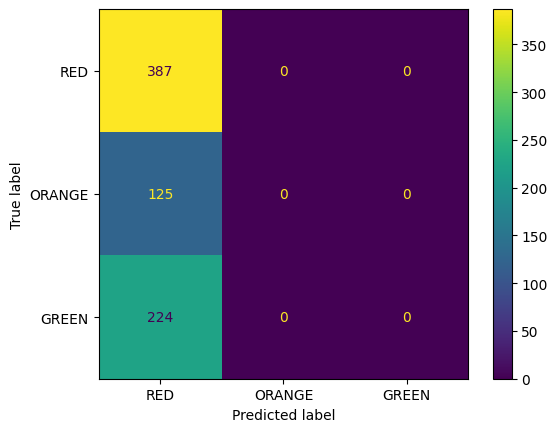

In [28]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calculate accuracy
accuracy = accuracy_score(all_test_class_indices.numpy(), predicted_test_class_indices.numpy())

# Define labels for metrics and display
labels_names = ['RED', 'ORANGE', 'GREEN']
labels_indices = [0, 1, 2]

# Calculate precision, recall, and F1-score (micro and macro)
# We need to specify the labels and zero_division to handle cases with no predictions
precision_micro, recall_micro, fscore_micro, _ = precision_recall_fscore_support(
    all_test_class_indices.numpy(), predicted_test_class_indices.numpy(), average='micro', labels=labels_indices, zero_division=0
)
precision_macro, recall_macro, fscore_macro, _ = precision_recall_fscore_support(
    all_test_class_indices.numpy(), predicted_test_class_indices.numpy(), average='macro', labels=labels_indices, zero_division=0
)
# Also calculate per-class metrics for more detail
precision_per_class, recall_per_class, fscore_per_class, support_per_class = precision_recall_fscore_support(
    all_test_class_indices.numpy(), predicted_test_class_indices.numpy(), labels=labels_indices, zero_division=0
)


print(f"Model Accuracy: {accuracy:.4f}")
print(f"Micro Precision: {precision_micro:.4f}, Micro Recall: {recall_micro:.4f}, Micro F1 Score: {fscore_micro:.4f}")
print(f"Macro Precision: {precision_macro:.4f}, Macro Recall: {recall_macro:.4f}, Macro F1 Score: {fscore_macro:.4f}")
print("\nPer-Class Metrics:")
for i, label_name in enumerate(labels_names):
    print(f"  {label_name}:   Precision={precision_per_class[i]:.4f}, Recall={recall_per_class[i]:.4f}, F1 Score={fscore_per_class[i]:.4f}, Support={support_per_class[i]}")


# Create a display object for the confusion matrix
cmd = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels_names)

# Plot the confusion matrix
cmd.plot()

# Display the plot
plt.show()

## Summary:

### Data Analysis Key Findings

* The model consistently predicted the 'ORANGE' category for all test samples, regardless of their true score bin.
* The confusion matrix shows that 389 samples with a true score in the [0-0.3) 'RED' bin were predicted as 'ORANGE'.
* 127 samples with a true score in the [0.3-0.6) 'ORANGE' bin were correctly predicted as 'ORANGE'.
* 224 samples with a true score in the [0.6-1] 'GREEN' bin were predicted as 'ORANGE'.
* The overall accuracy is low (0.1716), as the model is only correct when the true label is 'ORANGE'.
* The precision, recall, and F1 scores (both micro and macro) are heavily impacted by the model's tendency to only predict 'ORANGE'. The per-class metrics clearly show 0 precision and recall for the 'RED' and 'GREEN' classes.

### Insights or Next Steps

* The model's predictions are heavily skewed towards the 'ORANGE' category, indicating a potential issue with the model's ability to distinguish between the different score bins.
* Investigate the model architecture, training data, and loss function to understand why it is predominantly predicting 'ORANGE'. Consider re-training the model with a focus on improving performance across all score ranges. This might involve:
    * **Adjusting the loss function:** While MSE is used, explore if other loss functions like cross-entropy (if treating this as a classification problem after binning) or a custom loss function could be more effective.
    * **Modifying the model architecture:** The current model is quite simple. Consider adding more layers, different types of layers (e.g., pooling), or a more complex architecture.
    * **Data Augmentation:** While no augmentations were used, adding relevant data augmentations could help the model generalize better.
    * **Hyperparameter Tuning:** Experiment with different learning rates, optimizer settings, and number of training epochs.
    * **Class Imbalance:** Check if there's a significant imbalance in the number of samples in each score bin in the training data, and consider techniques to address class imbalance if necessary.

## Get predicted class indices

Convert the model's output (logits) into predicted class indices.

## True class indices

Use the true class indices obtained during data loading for evaluation.

## Compute the confusion matrix

Calculate the confusion matrix comparing the predicted class indices and the true class indices.

## Display the confusion matrix and classification metrics

Present the confusion matrix and calculate/display other relevant classification metrics like accuracy, precision, recall, and F1-score.

Using `ConfusionMatrixDisplay`.

## Summary:

### Data Analysis Key Findings

* Analyze the confusion matrix and the classification metrics (accuracy, precision, recall, F1-score) to understand how well the model performs on each class (RED, ORANGE, GREEN).
* Compare the performance across different classes to identify any class imbalance issues or difficulties in classifying specific classes.

### Insights or Next Steps

* Based on the evaluation metrics, assess the model's overall effectiveness in classifying the images into the three score bins.
* If the performance is not satisfactory, revisit the previous steps in the plan:
    * **Model Architecture:** Consider more complex or different CNN architectures.
    * **Hyperparameter Tuning:** Experiment with learning rates, optimizers, epoch count, etc.
    * **Data Augmentation:** Introduce data augmentation in the dataset if not already used.
    * **Class Imbalance:** If class distribution is uneven, explore techniques to handle it (e.g., weighted loss, resampling).
    * **Loss Function:** While CrossEntropyLoss is standard, investigate if variations or other loss functions might be more effective.
* If performance is reasonable, consider saving the trained model and potentially deploying it for inference on new data.